#**Deep Learning Homework 5: *Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Nicolò Navarin & Prof. Alessandro Sperduti
---


In this homework, we will deal with _dimensionality reduction_ and learn how to develop a simple _Autoencoder_.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset seen in HW4.

In [3]:
# import the usual libriaries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

np.random.seed(42)

### Load Dataset
We load the CIFAR-10 dataset, using `tf.keras.datasets`. The dataset contains 60,000 training images and 10,000 testing images.
The images are originally in RGB format, but we will convert them to grayscale for convenience. The value of each pixel is between 0 and 255, and it represents a point of an image of size 32 x 32. We will normalize all values between 0 and 1, and we will flatten the 32x32 images into vectors of size 1024.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [4]:
cifar_10 = keras.datasets.cifar10
(X_train_full, _), (x_test, _) = cifar_10.load_data() # The dataset is already divede in test and training

X_train_full, x_test = np.mean(X_train_full, -1), np.mean(x_test, -1)

X_train_full = X_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

X_train_full = X_train_full.reshape((len(X_train_full), np.prod(X_train_full.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# We extract the first 10000 samples of the training set, to use them as the validation set
x_valid, x_train = X_train_full[:10000], X_train_full[10000:]

## [TO COMPLETE] Exercise 5.1: Singular Value Decomposition

Similar to Principal component analysis (PCA), Singular Value Decomposition (SVD) is a standard linear dimensionality reduction method. They both linealry combine the features of the original high-dimensional dataset and project them into a lower-dimensional space, ideally retaing most of thier intrinsic properties.

In this first part of the HW, we will focus our attention on SVD decomposition and its performances. Given a matrix $X$, the SVD decomposes it into the product of two unitary matrices $V$ and $U$ and a rectangular diagonal matrix of singular values $S$:

$$ X=V \cdot S \cdot U^T.$$

The SVD is already implemented in NumPy as `np.linalg.svd`. In our case, the $X$ matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features). However, notice that the $X$ matrix has a huge number of rows (we have 50,000 input samples) and only 784 columns. If you are using the _Colab_ free plan, the quantity of available RAM may not be sufficient to compute the SVD of $X$. Therefore, to ease memory consumption and numerical stability, we resort to one property of the SVD and compute its equivalent version from the covariance matrix $C= X^T \cdot X$, that can be decomposed as:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix $U$ to compute the compressed version of our data, this trick turns out to be a quick and good solution.

In [5]:
def SVD(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k

Let's define the `ENCODING_DIM`, that will be the size of the compressed version of input data, and project the low-dimensional versions of the training set and the test set as well.

In [6]:
ENCODING_DIM = 120

U_k = SVD(x_train, ENCODING_DIM)

x_training_svd = np.dot(x_train, U_k)
x_test_svd = np.dot(x_test, U_k)


We now reconstruct back the original input and check how much information was lost due to the compression. We do so by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [7]:
x_training_reco = np.dot(x_training_svd, U_k.T)
x_test_reco = np.dot(x_test_svd, U_k.T)

In [8]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))

Training mse: 0.00372
Test mse: 0.00375


In [9]:
def plot_img(n, images_sets: list, title=""):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    for set_idx, images in enumerate(images_sets):
      ax = plt.subplot(len(images_sets), n, i + 1 + set_idx*n)
      plt.imshow(images[i].reshape(32, 32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.suptitle(title)
  plt.show()

Let's see how well the input can be reconstructed by displaying a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images corresponds to input data, while the second one contains the reconstructions.

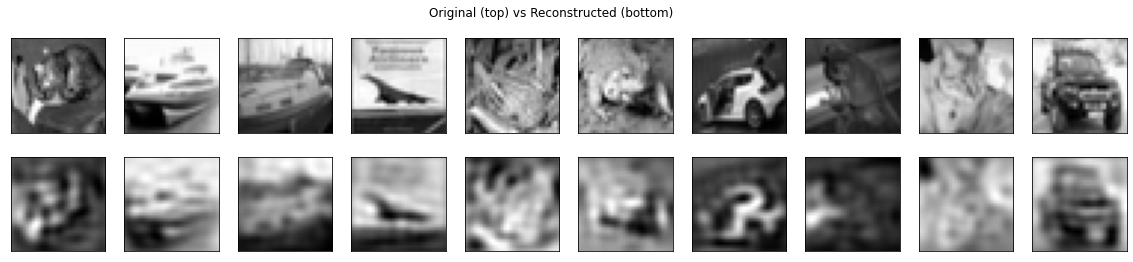

In [10]:
plot_img(10, [x_test, x_test_reco], title = "Original (top) vs Reconstructed (bottom)")

**[TO COMPLETE]**: What happens by varying the `ENCODING_DIM`? Try it out and discuss the results in this cell.

_Answer:_

## [TO COMPLETE] Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous HW when we used `Keras.Sequential()`, here we define the two parts of the model (encoder and decoder) separately and then we create the final model. 


In [11]:
ENCODING_DIM = 256
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

# ...the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='linear')(encoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

Print the model summary.

In [12]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              263168    
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [13]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
79/79 [==============================] - 1s 5ms/step - loss: 0.1764 - val_loss: 0.0304
Epoch 2/15
79/79 [==============================] - 0s 3ms/step - loss: 0.0291 - val_loss: 0.0323
Epoch 3/15
79/79 [==============================] - 0s 3ms/step - loss: 0.0227 - val_loss: 0.0163
Epoch 4/15
79/79 [==============================] - 0s 3ms/step - loss: 0.0148 - val_loss: 0.0136
Epoch 5/15
79/79 [==============================] - 0s 3ms/step - loss: 0.0125 - val_loss: 0.0117
Epoch 6/15
79/79 [==============================] - 0s 3ms/step - loss: 0.0109 - val_loss: 0.0104
Epoch 7/15
79/79 [==============================] - 0s 3ms/step - loss: 0.0098 - val_loss: 0.0097
Epoch 8/15
79/79 [==============================] - 0s 3ms/step - loss: 0.0095 - val_loss: 0.0085
Epoch 9/15
79/79 [==============================] - 0s 3ms/step - loss: 0.0080 - val_loss: 0.0078
Epoch 10/15
79/79 [==============================] - 0s 3ms/step - loss: 0.0085 - val_loss: 0.0072
Epoch 11/15
79/79 [

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [14]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.grid()
  plt.title('loss')

313/313 - 0s - loss: 0.0052
Test mse: 0.00521


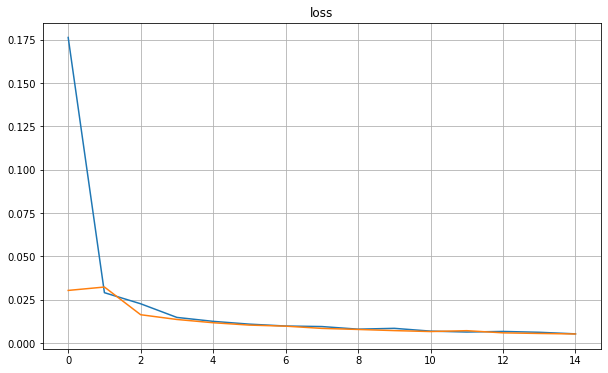

In [15]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

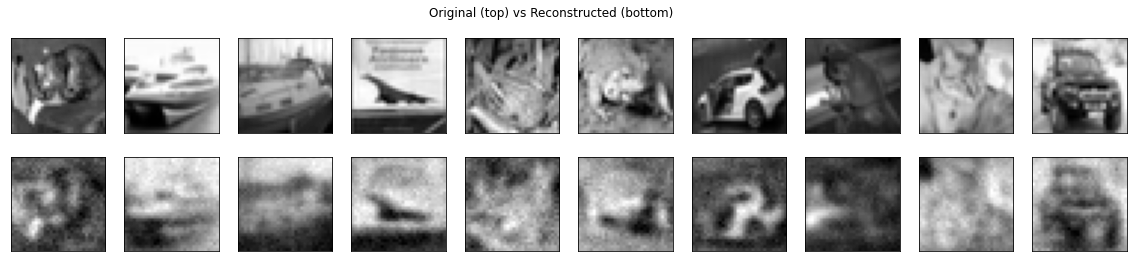

In [16]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

**[TO COMPLETE]** Check the results and compare them versus the results obtained with the SVD. Give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.


_Answer:_

SVD ------> 0.00375

Shallow --> 0.00362

It's easy to see from the metric that the two performs nealry the same. 

In fact they are equivalent methods: we can see that the shallow linear autoencoder can compute what the SVD method do. The output of the SVD is $O=XU_kU_k^T$, i.e. $O^T=U_kU_k^TX^T$; then a linear neural netwrok with a hidden layer can compute the following transofrmation: $o = W_2W_1x$, so the NN can learn $W_1=U_k^T$ and $W_2=U_k$ 
This means that the NN can compute the following : $o^T=U_kU_k^Tx^T$.
 In this case in the hidden layer we would have stored the encoding $(xU_k)^T$. Then since the SVD method finds the best base (that which minimizes the mean squared distance of a point from the space generated by the dataset) and the NN optimization minimizes with a MSE loss the objective is the same and so the models are equivalent.

We can also arge that both the model a MSE, but for different funct. Tha SVD try to find the best base minimizing the MSE of a point from the dataset space, while the NN minimize the NN use the MSE loss funct. 

However there are some difference in the computation time, normal result since the SVD is deterministic while the shallow NNN is probabilistic.


##[TO COMPLETE] Exercise 5.3: Shallow Non-linear Autoencoders

**[TO COMPLETE]** Replicate the code of Exercise 5.2 but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.2. 

Insert your code and theoretical discussion into cells immediately below this one.


In [17]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

In [18]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
79/79 [==============================] - 1s 5ms/step - loss: 0.0371 - val_loss: 0.0248
Epoch 2/15
79/79 [==============================] - 0s 4ms/step - loss: 0.0216 - val_loss: 0.0184
Epoch 3/15
79/79 [==============================] - 0s 4ms/step - loss: 0.0167 - val_loss: 0.0156
Epoch 4/15
79/79 [==============================] - 0s 4ms/step - loss: 0.0148 - val_loss: 0.0135
Epoch 5/15
79/79 [==============================] - 0s 3ms/step - loss: 0.0133 - val_loss: 0.0122
Epoch 6/15
79/79 [==============================] - 0s 4ms/step - loss: 0.0121 - val_loss: 0.0113
Epoch 7/15
79/79 [==============================] - 0s 3ms/step - loss: 0.0114 - val_loss: 0.0107
Epoch 8/15
79/79 [==============================] - 0s 3ms/step - loss: 0.0108 - val_loss: 0.0110
Epoch 9/15
79/79 [==============================] - 0s 3ms/step - loss: 0.0105 - val_loss: 0.0098
Epoch 10/15
79/79 [==============================] - 0s 4ms/step - loss: 0.0097 - val_loss: 0.0100
Epoch 11/15
79/79 [

313/313 - 0s - loss: 0.0106
test mse: 0.01062


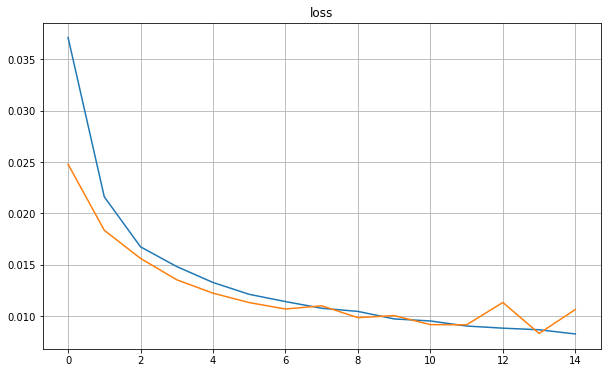

In [19]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

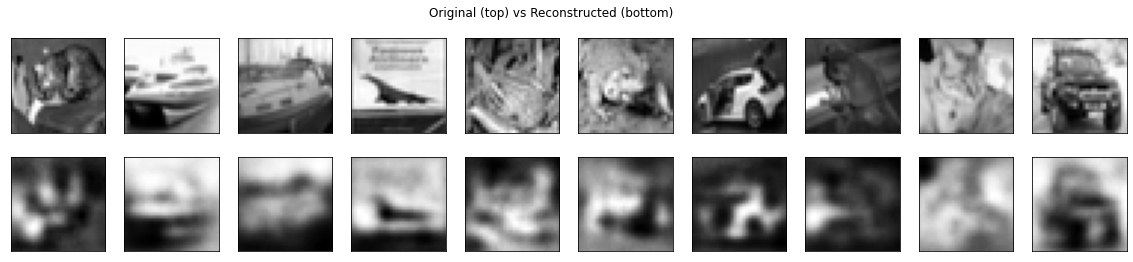

In [20]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")


Since the output must be in between 0 and 1 I choosed the sigmoid activation function. This revelaed to be NOT a good chooice since we got an worsening from the linear shallow model, obtaining an MSE higer than that of SVD. 

This worsening surpised me since last year doing teh same i obtained an imporvement in terms of performance..

Maybe the problem is the differenet dataset used...

##[TO COMPLETE] Exercise 5.4: Deep Autoencoder
**[TO COMPLETE]** Build a deep version of the Autoencoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and $n-1$ for decoding. The layers sizes of the encoding part decrease at each layer (e.g., `INPUT_DIM->128->64`, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (e.g., `128->INPUT_DIM`, the final overall structure recalls an hourglass ⏳).
As usual, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


In [21]:
INPUT_DIM = x_train.shape[-1]

print(INPUT_DIM)

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# encoder
encoded_1 = tf.keras.layers.Dense(INPUT_DIM, activation='tanh')(input_img)
encoded_2 = tf.keras.layers.Dense(512, activation='relu')(encoded_1)
encoded = tf.keras.layers.Dense(256, activation='sigmoid')(encoded_2)

# decoder
decoded_1 = tf.keras.layers.Dense(512, activation='relu')(encoded)
decoded_2 = tf.keras.layers.Dense(INPUT_DIM, activation='tanh')(decoded_1)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(decoded_2)

# autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# to visualize the learned encoding, define a model that computes the two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(256,))
decoder_layer = autoencoder.layers[-3]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='mse')

1024


In [22]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              1049

In [23]:
history = autoencoder.fit(x_train, x_train, epochs=30, batch_size=16, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/30
2500/2500 [==============================] - 5s 2ms/step - loss: 0.0186 - val_loss: 0.0145
Epoch 2/30
2500/2500 [==============================] - 5s 2ms/step - loss: 0.0136 - val_loss: 0.0145
Epoch 3/30
2500/2500 [==============================] - 5s 2ms/step - loss: 0.0126 - val_loss: 0.0130
Epoch 4/30
2500/2500 [==============================] - 5s 2ms/step - loss: 0.0122 - val_loss: 0.0124
Epoch 5/30
2500/2500 [==============================] - 5s 2ms/step - loss: 0.0117 - val_loss: 0.0112
Epoch 6/30
2500/2500 [==============================] - 5s 2ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 7/30
2500/2500 [==============================] - 5s 2ms/step - loss: 0.0111 - val_loss: 0.0111
Epoch 8/30
2500/2500 [==============================] - 5s 2ms/step - loss: 0.0110 - val_loss: 0.0107
Epoch 9/30
2500/2500 [==============================] - 5s 2ms/step - loss: 0.0108 - val_loss: 0.0105
Epoch 10/30
2500/2500 [==============================] - 5s 2ms/step - loss: 0.010

313/313 - 0s - loss: 0.0092
test mse: 0.00919


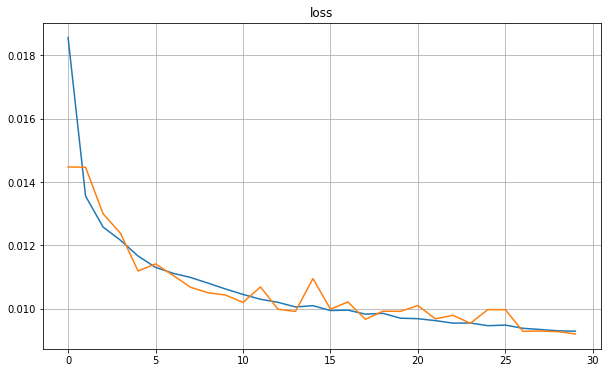

In [24]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

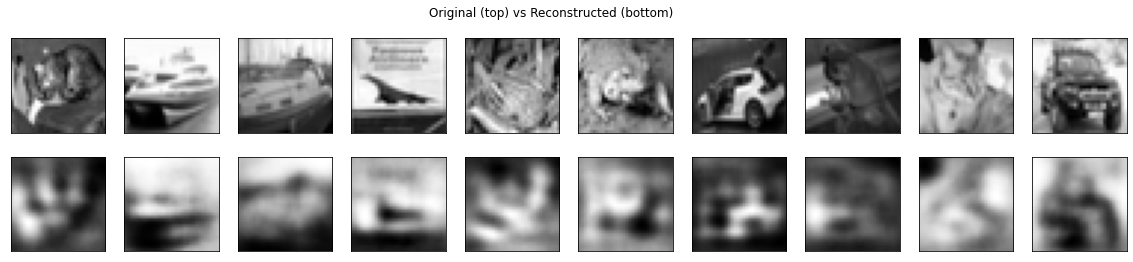

In [25]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

## [TO COMPLETE] Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data. The idea is that only meaningful information will be encoded, thus filtering out useless noise.
Firstly, define a noisy input by adding some gaussian noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.

In [26]:
noise_factor = 0.3

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)

# we still have to be sure that the color values are in the [0,1] range:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs:

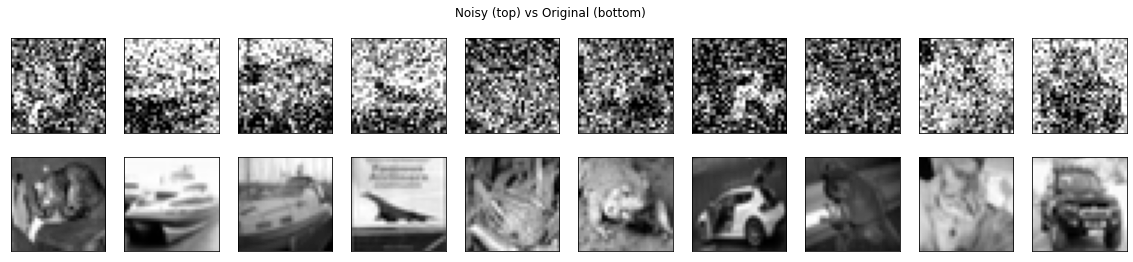

In [27]:
plot_img(10, [x_test_noisy, x_test], title = "Noisy (top) vs Original (bottom)")

**[TO COMPLETE]** Define a shallow autoencoder able to compute a de-noised version of the input (use a noise_factor $\geq 0.3$). 

In [28]:
INPUT_DIM = x_train.shape[-1]

ENCODING_DIM = 256

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))

# encoder
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='relu')(input_img)
# decoder
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)

#[TO COMPLETE]
autoencoder = tf.keras.models.Model(input_img, decoded)

encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')

In [29]:
autoencoder.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              263168    
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


**[TO COMPLETE]** Train the model by passing the noisy input and the clean target.

In [30]:
history = autoencoder.fit(x_train_noisy, x_train, epochs=30, batch_size=16, shuffle=True, validation_data=(x_valid_noisy, x_valid))

Epoch 1/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0239 - val_loss: 0.0152
Epoch 2/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0142 - val_loss: 0.0135
Epoch 3/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0131 - val_loss: 0.0129
Epoch 4/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0127 - val_loss: 0.0126
Epoch 5/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0125 - val_loss: 0.0125
Epoch 6/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0124 - val_loss: 0.0124
Epoch 7/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0123 - val_loss: 0.0125
Epoch 8/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0123 - val_loss: 0.0127
Epoch 9/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.0123 - val_loss: 0.0125
Epoch 10/30
2500/2500 [==============================] - 3s 1ms/step - loss: 0.012

313/313 - 0s - loss: 0.0124
Test mse: 0.01239


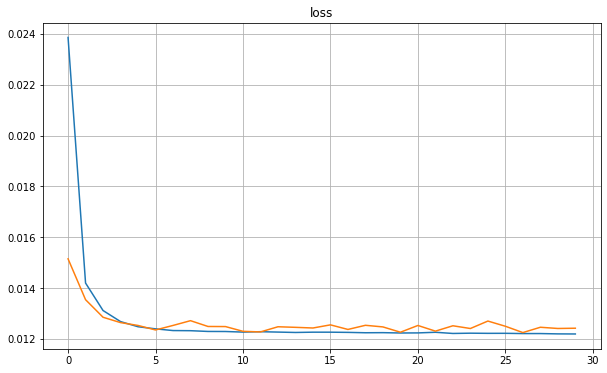

In [31]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

**[TO COMPLETE]** Check the result by plotting some input images and the corresponding denoised outputs.

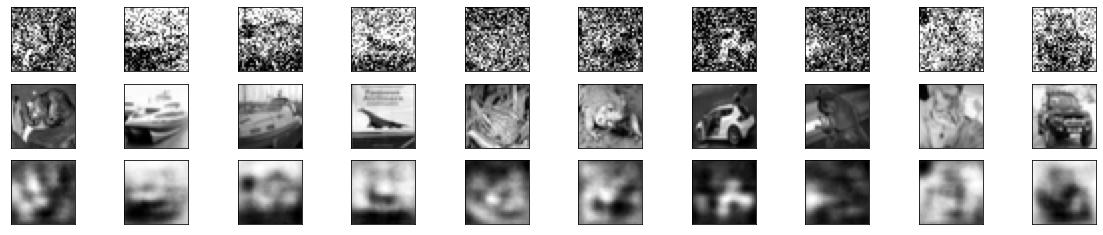

In [32]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, [x_test_noisy, x_test, decoded_imgs])

## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case we will use the IMDB dataset (already introduced in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in _Colab_), we will limit the number of training samples and test samples.

In [33]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [34]:
from tensorflow.keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)

Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using `tf.keras.layers.SimpleRNN`. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [35]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 90, 100)]         0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 90, 50)            7550      
_________________________________________________________________
time_distributed (TimeDistri (None, 90, 100)           5100      
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 5s 61ms/step - loss: 0.1873 - categorical_accuracy: 0.1319 - val_loss: 0.0850 - val_categorical_accuracy: 0.3669
Epoch 2/50
79/79 [==============================] - 4s 56ms/step - loss: 0.0703 - categorical_accuracy: 0.4401 - val_loss: 0.0633 - val_categorical_accuracy: 0.4720
Epoch 3/50
79/79 [==============================] - 5s 57ms/step - loss: 0.0586 - categorical_accuracy: 0.5095 - val_loss: 0.0547 - val_categorical_accuracy: 0.5294
Epoch 4/50
79/79 [==============================] - 5s 57ms/step - loss: 0.0558 - categorical_accuracy: 0.5212 - val_loss: 0.0501 - val_categorical_accuracy: 0.5703
Epoch 5/50
79/79 [==============================] - 5s 57ms/step - loss: 0.0457 - categorical_accuracy: 0.5890 - val_loss: 0.0436 - val_categorical_accuracy: 0.6067
Epoch 6/50
79/79 [==============================] - 4s 56ms/step - loss: 0.0404 - categorical_accuracy: 0.6167 - val_loss: 0.0388 - val_categorical_accuracy: 0.6244
Epoch 7/50

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 0s - loss: 0.0096 - categorical_accuracy: 0.9467
categorical_accuracy: 94.67%


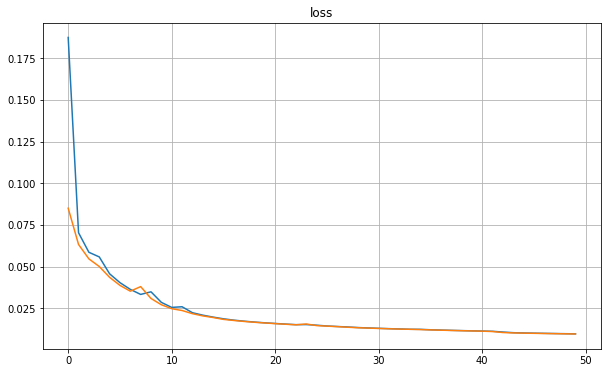

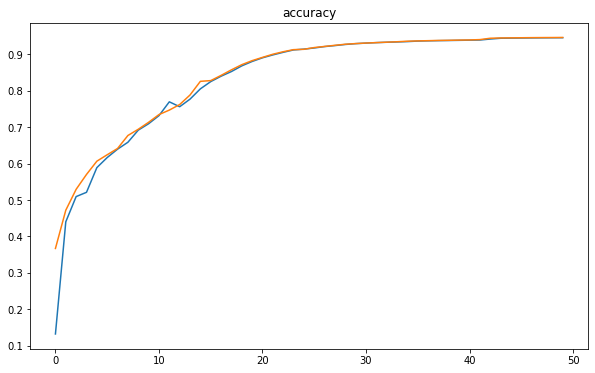

In [37]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [38]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> and are <oov> in all of them time but br <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film was <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


##[TO COMPLETE] Exercise 5.7: Non-Linear Autoencoder for sequences
**[TO COMPLETE]**: Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

In [39]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, return_sequences=True, activation='tanh')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 90, 50)            30200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 90, 100)           5100      
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________


In [40]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=32, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
313/313 [==============================] - 5s 10ms/step - loss: 0.0361 - categorical_accuracy: 0.4630 - val_loss: 0.0292 - val_categorical_accuracy: 0.4921
Epoch 2/50
313/313 [==============================] - 3s 9ms/step - loss: 0.0213 - categorical_accuracy: 0.6373 - val_loss: 0.0144 - val_categorical_accuracy: 0.7831
Epoch 3/50
313/313 [==============================] - 3s 8ms/step - loss: 0.0098 - categorical_accuracy: 0.8511 - val_loss: 0.0065 - val_categorical_accuracy: 0.8995
Epoch 4/50
313/313 [==============================] - 3s 8ms/step - loss: 0.0042 - categorical_accuracy: 0.9546 - val_loss: 0.0025 - val_categorical_accuracy: 0.9945
Epoch 5/50
313/313 [==============================] - 3s 8ms/step - loss: 0.0015 - categorical_accuracy: 0.9982 - val_loss: 8.2387e-04 - val_categorical_accuracy: 0.9999
Epoch 6/50
313/313 [==============================] - 3s 8ms/step - loss: 5.4799e-04 - categorical_accuracy: 1.0000 - val_loss: 3.7433e-04 - val_categorical_accuracy

40/40 - 0s - loss: 3.7266e-07 - categorical_accuracy: 1.0000
categorical_accuracy: 100.00%


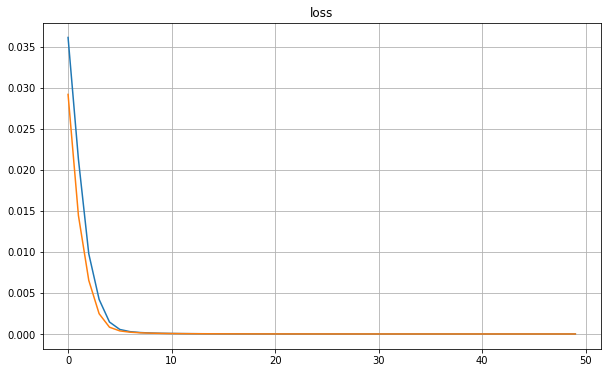

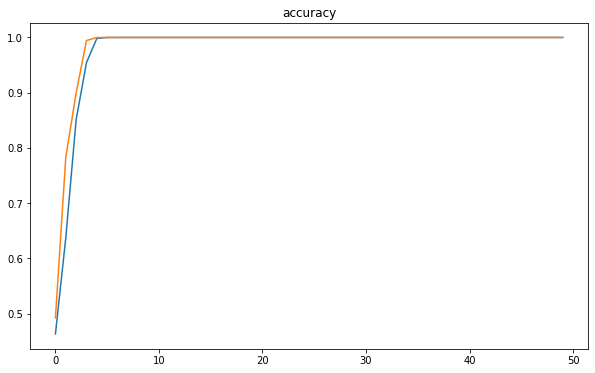

In [41]:
plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))



In [42]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


we studied that LSTM uses tanh act funct. I tried to use the same act funct here and the model works well. 
I briefley tested also other act function and none reached the performances as high as the tanh

in the RNN we tend to have error cloes to the end of the sequence, maybe due to gradient vanishing...in the LSTM sussists no problem such this one since is build to be "anti" vanishing gradient

softmax is a good choise for the second act funct since the problem we are facing isa multiclass problem